In [6]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.ops.numpy_ops import np_utils
from transformers import BertModel, TFBertModel 
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras import regularizers
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [7]:
import pandas as pd
from matplotlib import rcParams
import seaborn as sns
import numpy as np
from PIL import Image
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from transformers import AutoTokenizer

In [8]:
fake_data=pd.read_csv("Fake.csv")
real_data=pd.read_csv("True.csv")

In [9]:
fake_data.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


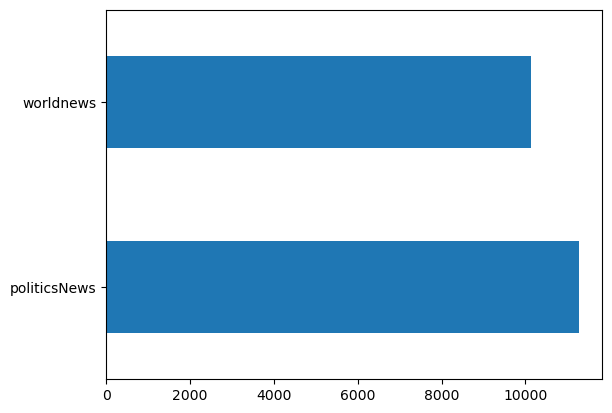

In [10]:
real_data['subject'].value_counts().plot(kind='barh')
rcParams['figure.figsize'] = 5,5

In [11]:
fake_text=" ".join(fake_data["text"].tolist())

In [12]:
fake_data["label"]="fake"
real_data["label"]="real"

In [13]:
final_data= pd.concat([fake_data,real_data])

In [14]:
final_data = final_data.sample(frac=1).reset_index(drop=True)

In [15]:
final_data.isnull().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

In [16]:
final_data.drop(["subject","date"], axis=1)

,title,text,label
0,"After Yemeni air strike, little girl is family...",SANAA (Reuters) - Her bruised eyes still swoll...,real
1,Trump’s White Supremacist Fans Say ‘Rational’...,Everyone thinks of people like the KKK when th...,fake
2,Obamacare supporters rally against congression...,WASHINGTON (Reuters) - Supporters of Obamacare...,real
3,Treasury secretary's wife apologizes for Insta...,(Reuters) - The wife of U.S. Treasury Secretar...,real
4,HERE’S ALL THE PROOF YOU NEED That The Media I...,SHARE this everywhere REMEMBER WHEN THE MEDIA ...,fake
...,...,...,...
44893,WATCH INSANE VIDEOS…CHICAGO COP Spills The Bea...,The leftist media was quick to blame Donald Tr...,fake
44894,FDP's push to invite Putin to G7 sows discord ...,BERLIN (Reuters) - The leader of Germany s pro...,real
44895,TRUMP’S HISTORIC SPEECH: 4 Words That Will Cau...,Trump talked about a country on the brink of d...,fake
44896,OBAMA TRIES TO CONDEMN TRUMP SUPPORTERS But Ge...,How dare Obama the worst president and most di...,fake


In [17]:
final_data["text"]=final_data["title"]+final_data["text"]

In [18]:
final_data=final_data[["text","label"]]

In [19]:
final_data['label'] = final_data['label'].map({'real':1, 'fake':0})

In [20]:
max_len=100
data_text=final_data["text"]
data_label=final_data["label"]

In [21]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [22]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [23]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [24]:
X_train, X_test, Y_train, Y_test = train_test_split(data_text, data_label, stratify = data_label, test_size = 0.2, random_state =42)

In [25]:
def tokenize(X):
    
    X = bert_tokenizer(
        text = list(X),
        add_special_tokens = True,
        max_length = 100,
        truncation = True,
        padding = 'max_length',
        return_tensors = 'tf',
        return_token_type_ids = False,
        return_attention_mask = True,
        verbose = True
        )
    return X

In [26]:
X_train_token = tokenize(X_train)
X_test_token = tokenize(X_test)

In [27]:
maxlen=100

In [28]:
def create_model():
    dropout_rate=0.2
    input_ids=Input(shape=(maxlen,),dtype=tf.int32)
    input_mask=Input(shape=(maxlen,),dtype=tf.int32)
    bert_layer=bert_model([input_ids,input_mask])[1]
    x=Dropout(0.5)(bert_layer)
    x=Dense(64,activation="tanh")(x)
    x=Dropout(0.2)(x)
    x=Dense(1,activation="sigmoid")(x)
    model = Model(inputs=[input_ids, input_mask], outputs=x)
    return model
    

In [29]:
model=create_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 100,                                           

In [30]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-05, epsilon=1e-08, decay=0.01,clipnorm=1.0)
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = 'accuracy')

In [31]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='max', verbose=1, patience=50,baseline=0.4,min_delta=0.0001,restore_best_weights=False)

In [35]:
history = model.fit(x = {'input_1':X_train_token['input_ids'],'input_2':X_train_token['attention_mask']}, y = Y_train, epochs=1, validation_split = 0.2, batch_size = 5, callbacks=[callback])

5747/5747 [==============================] - 1602s 279ms/step - loss: 0.0187 - accuracy: 0.9946 - val_loss: 0.0069 - val_accuracy: 0.9987


In [36]:
model.save("model.h5");

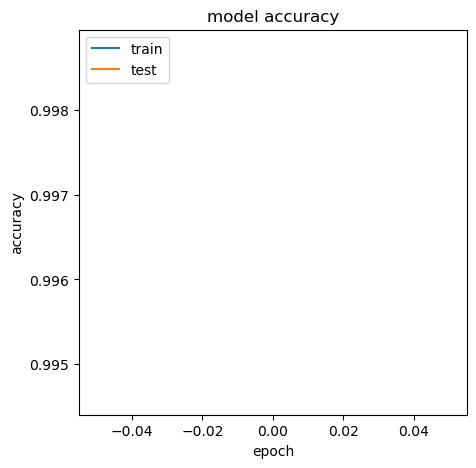

In [37]:
# summarize history for accuracy
print(history)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [41]:
y_pred = np.where(model.predict({ 'input_1' : X_test_token['input_ids'] , 'input_2' : X_test_token['attention_mask']}) >=0.5,1,0)

281/281 [==============================] - 105s 362ms/step


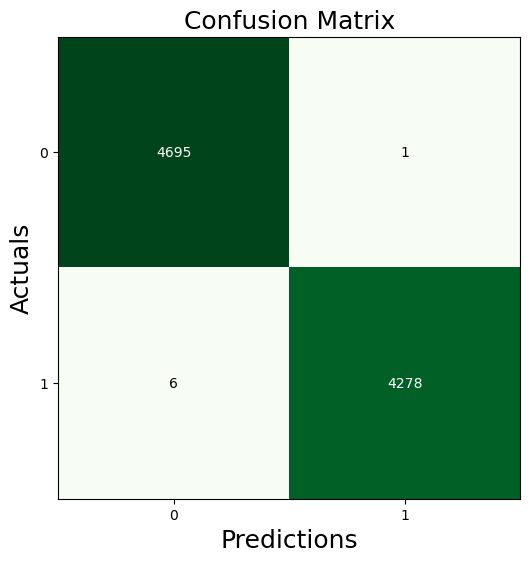

In [42]:
from mlxtend.plotting import plot_confusion_matrix
conf_matrix = confusion_matrix(Y_test,y_pred)
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [1]:
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(Y_test,y_pred)
print(classification_report(Y_test,y_pred))
print("Model Accuracy : ", accuracy)

NameError: name 'Y_test' is not defined

In [48]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """

    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

In [46]:
y_prob = np.where(model.predict({ 'input_1' : X_test_token['input_ids'] , 'input_2' : X_test_token['attention_mask']}))

281/281 [==============================] - 103s 366ms/step


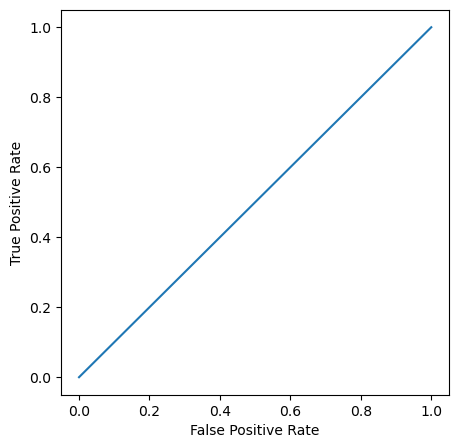

In [52]:

plot_roc_curve(Y_test, y_prob[1])

In [ ]:
test_text="Cop Shares Racist Meme About Michelle Obama; Now That Cop Is Having A VERY Bad Day (IMAGES)After the election of Donald Trump many folks seem to see it as a permission slip to be as racist and vile as possible. However, here s the thing, you re still going to get called out as racist and vile. And one Alabama police officer just found this out the hard way.According to the Washington Post: Talladega Police Officer Joel Husk was terminated Wednesday for violating the department s social media and code of conduct policies, City Manager Patrick Bryant said. What did he do? So glad you asked: Husk had posted several memes on his Facebook page, including one showing Obama and Melania Trump.  Fluent in Slovenian, English, French, Serbian, and German,  it said over Trump s photo. Over Obama s, it read:  Fluent in Ghetto. Not only that, he posted several extraordinarily racist memes:via Washington Postvia Washington PostAccording to the City Manager, the statements were  deemed to be biased or racially insensitive or derogatory  and because of that, they  have to take action to correct it. If you re going to be a police officer and serve all the public, you can t assume black people standing up for their rights are equivalent to the KKK. That s about the most horrific equivalence imaginable.Also, according to WaPo: Husk, 37, who had been with the department for about two and a half years, had also shared a meme showing President Obama with the words:  Was Dallas a terrorist attack? Yes! Carried out by Obama s own homegrown terrorist group! Which is a blatant lie and anyone who were to feel that way belongs nowhere near law enforcement. The city took the proper action letting this racist cop go, and hopefully it will be an example to police departments all over the country that this sort of behavior simply cannot be tolerated.Trump s election must not be allowed to serve as a permission slip to bigots everywhere that it s fine to be as awful as possible, because here in the land of the free and the home of the brave, everyone is protected. Everyone, regardless of color, class, gender, sexual orientation, or creed.Featured Photo by Chip Somodevilla/Getty Images'"

In [ ]:
test_token = tokenize(test_text)

In [ ]:
test_text_pred = np.where(model.predict({ 'input_1' : test_token['input_ids'] , 'input_2' : test_token['attention_mask']}) >=0.5,1,0)

69/69 [==============================] - 249s 4s/step


In [ ]:
test_text_pred = np.where(model.predict({ 'input_1' : test_token['input_ids'] , 'input_2' : test_token['attention_mask']}) >=0.5,1,0)

69/69 [==============================] - 244s 4s/step


In [ ]:
if(test_text_pred[0]==0):
    print("News is Fake")
else:
    print("News is Real")

News is Real
